In [1]:
import LinearAlgebra
const la = LinearAlgebra
MAX_ITER = 100;

In [2]:
A = [4. -1 0 -1 0 0;
     -1 4 -1 0 -1 0;
     0 -1 4. 0 0 -1;
     -1 0 0. 4 -1 0;
     0 -1 0 -1 4 -1;
     0 0 -1 0. -1 4]

b = [0, 5, 0, 6, -2, 6.]

x0 = zeros(size(b));
# n
x1 = [1., 0, 2, 0, 1, 1];

### Util

In [3]:
function e_vector(m:: Int64, k:: Int64)
    e = zeros(m)
    e[k] = 1.0
    return e
end

e_vector (generic function with 1 method)

In [4]:
function omega(H:: Matrix, i:: Int64)
    # Input: (m + 1) x m matrix H and column i
    # Output: (m + 1) x (m + 1) matrix O
    m = size(H, 2)
    O = 1.0 * Matrix(la.I, m + 1, m + 1) 
    hyp = sqrt(H[i, i]^2 + H[i + 1, i]^2)
    si = H[i + 1, i]/hyp
    ci = H[i, i]/hyp
    
    O[i, i] = ci
    O[i, i + 1] = si
    O[i + 1, i] = -si
    O[i + 1, i + 1] = ci
    return O 
end

omega (generic function with 1 method)

In [5]:
function givens(H:: Matrix, beta:: Vector)
    # Input: (m + 1) x m matrix H and (m + 1) x 1 vector beta
    # Output: (m + 1) x m matrix R, (m + 1) x (m + 1) matrix Q and (m + 1) x 1 vector gamma 
    m = size(H, 2)
    R = copy(H)
    for i = 1:m
        upper_omega = omega(R, i)
        beta = upper_omega * beta
        R = upper_omega * R
    end
    # delete last row, page 176 book 1
    return R[1:m, :], beta[1:m]
end

givens (generic function with 1 method)

### Arnoldi

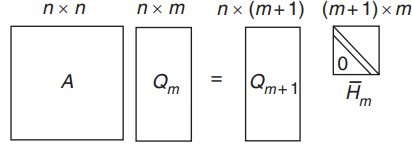

In [6]:
function arnoldi(A:: Matrix, x1:: Vector, m:: Int64)
    # Input: nxn matrix A, nx1 column vector x1, and integer m
    # Output: m+1 orthogonal vectors q1,q2,...,q{m+1} and (m+1)xm matrix H
    n = size(A, 1)
    Q = zeros((n, m + 1))
    H = zeros((m + 1, m))
    
    Q[:, 1] = x1/la.norm(x1)
    for k = 1:m
        w = A*Q[:, k]
        for j = 1:k
            H[j, k] = la.dot(w, Q[:, j])
            w = w - H[j, k] * Q[:, j]
        end
        H[k+1, k] = la.norm(w)
        if H[k+1, k] < eps()
            break
        end
        Q[:, k+1] = w/H[k+1, k]
    end
    Q, H
end

arnoldi (generic function with 1 method)

In [7]:
m = 3
Q, H = arnoldi(A, x1, m)
display(Q)
display(H)

6×4 Matrix{Float64}:
 0.377964   0.168563    0.289595   -0.585252
 0.0       -0.786629    0.191845    0.228787
 0.755929   0.140469   -0.282287    0.128662
 0.0       -0.393314    0.0959226  -0.699892
 0.377964  -0.0280939   0.750937    0.313906
 0.377964  -0.421408   -0.475959    0.0140224

4×3 Matrix{Float64}:
 3.14286  1.92195  -2.9976e-15
 1.92195  4.6472    1.18932
 0.0      1.18932   3.95556
 0.0      0.0       0.812257

It's verified that $AQ_m = Q_{m+1}\overline H_{m}$ or $AQ_m = Q_m H_m + h_{m+1, m}q_{m+1}e_m^T$, where $H_m$ is $\overline H_m$ without the last row.

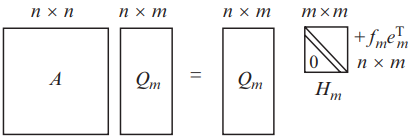

In [8]:
isapprox(Q[:, 1:m]*H[1:m, :] + (H[m+1, m]*Q[:, m+1])* e_vector(m, m)', A*Q[:, 1:m], rtol=sqrt(eps()))

true

In [9]:
isapprox(A*Q[:, 1:m], Q*H)

true

### GMRES

In [10]:
function GMRES(A:: Matrix, b:: Vector, x0:: Vector, m:: Int64, tol=1.0e-5)
    # Solve Ax = b using the GMRES method
    # Input: n x n matrix A, n x 1 vector b,
    # initial approximation x0, integer m < n,
    # error tolerance tol
    println("x[0] = $x0")
    for i = 1:MAX_ITER
        r = b - A*x0
        Q, H = arnoldi(A, r, m)
        beta = la.norm(r)
        # Solve the (m + 1) x m least-squares problem using Givens transformation
        R, g = givens(H, beta*e_vector(m + 1, 1))
        y = la.inv(R)*g
        x = x0 + Q[:, 1:m]*y
        println("x[$i] = $x")
        if la.norm(x0 - x) < tol
            print("Number of iterations: $i")
            return nothing
        end
        x0 = copy(x)
    end
    print("There's convergence")
end

GMRES (generic function with 2 methods)

In [11]:
m = 3
GMRES(A, b, x0, m)

x[0] = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
x[1] = [0.9905665343243519, 1.9904398530223673, 0.9905665343243519, 2.0051849096588614, 1.0109017962460918, 2.0051849096588614]
x[2] = [0.9999434000739091, 1.9998868001478185, 0.9999434000739091, 1.9998868001478183, 0.9999434000739091, 1.9998868001478183]
x[3] = [0.99999946606654, 1.9999994588963876, 0.99999946606654, 2.0000002934655035, 1.0000006170408617, 2.0000002934655035]
x[4] = [0.9999999967964484, 1.9999999935928967, 0.9999999967964484, 1.9999999935928967, 0.9999999967964484, 1.9999999935928967]
Number of iterations: 4

### References

[1] William Ford. *Numerical Linear Algebra with Applications Using MATLAB*, chapter 21.